# Single Condition Classifier

### Prepare Data

In [1]:
import sys
sys.path.append("..")
import numpy as np
import sklearn as sk
from sklearn.metrics import classification_report
import torch
from torch import nn, cuda
import matplotlib.pyplot as plt
import prepare_data
from prepare_data import DataPreparationContext
from prepare_data import ClassEmbedders
import models
from models import GenericMutliClassifier

In [2]:
def embedder(diseases, classes, classes_lookup):
    if len(diseases) <= 1:
        return None
    else:
        return ClassEmbedders.match_exact(diseases, classes, classes_lookup)
    
data_context = DataPreparationContext(combine_riskiest=16, verbose=True, classes=prepare_data.CLASSES_COMORBID, class_embedder=embedder)

training_data = data_context.prepare_from_file("../../symptom_sum_top16/train.pkl", oversample=True)
X_train_np = training_data['X']
y_train_np = training_data['y']

validation_data = data_context.prepare_from_file("../../symptom_sum_top16/val.pkl", oversample=False)
X_val_np = validation_data['X']
y_val_np = validation_data['y']

test_data = data_context.prepare_from_file("../../symptom_sum_top16/test.pkl", oversample=False)
X_test_np = test_data['X']
y_test_np = test_data['y']




100%|██████████| 21300/21300 [00:00<00:00, 99583.64it/s]


Input File: ../../symptom_sum_top16/train.pkl
 [anxiety depression] has 310
 [depression ptsd] has 310
 [anxiety depression ptsd] has 310
 [anxiety ptsd] has 310



100%|██████████| 2662/2662 [00:00<00:00, 110898.26it/s]


Input File: ../../symptom_sum_top16/val.pkl
 [anxiety depression] has 44
 [depression ptsd] has 2
 [anxiety depression ptsd] has 7
 [anxiety ptsd] has 3



100%|██████████| 2643/2643 [00:00<00:00, 77742.56it/s]

Input File: ../../symptom_sum_top16/test.pkl
 [anxiety depression] has 44
 [anxiety depression ptsd] has 3
 [anxiety ptsd] has 7
 [depression ptsd] has 2



## Deep Learning

### Convert to Tensors

In [3]:
X_train = models.convert_to_tensors(X_train_np).type(torch.float32).to(models.device)
y_train = models.convert_to_tensors(y_train_np).type(torch.LongTensor).to(models.device)
X_val = models.convert_to_tensors(X_val_np).type(torch.float32).to(models.device)
y_val = models.convert_to_tensors(y_val_np).type(torch.LongTensor).to(models.device)
X_test = models.convert_to_tensors(X_test_np).type(torch.float32).to(models.device)
y_test = models.convert_to_tensors(y_test_np).type(torch.LongTensor).to(models.device)

### Define Model

The models used are based on tutorial:
```
Bourke , D 2022, PyTorch for Deep Learning & Machine Learning – Full Course, in freeCodeCamp.org (ed.), YouTube, viewed 6 May 2024, <https://www.youtube.com/watch?v=V_xro1bcAuA>.
```

### Train Model

                         precision    recall  f1-score   support

     anxiety depression       0.79      0.93      0.85        44
        depression ptsd       0.00      0.00      0.00         2
           anxiety ptsd       0.50      0.14      0.22         7
anxiety depression ptsd       0.00      0.00      0.00         3

               accuracy                           0.75        56
              macro avg       0.32      0.27      0.27        56
           weighted avg       0.68      0.75      0.70        56



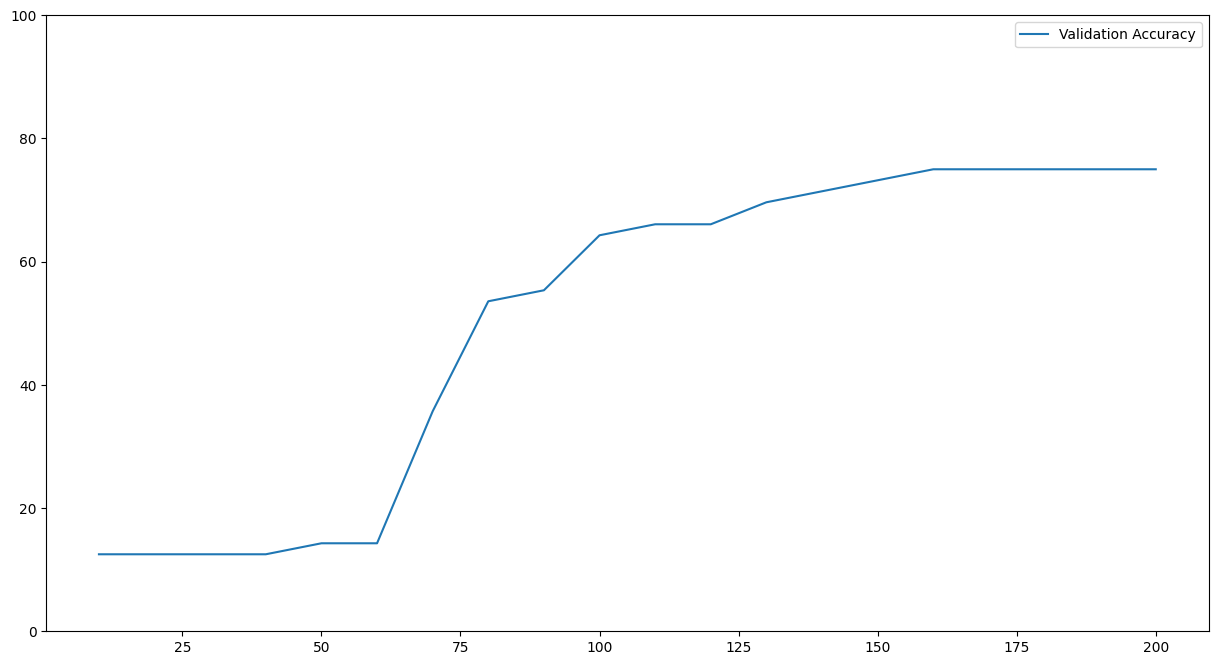

In [16]:
models.begin_plot()

hidden_layers = 250
epochs = 200
learning_rate = 0.0001
labels = [(' '.join(x) if len(' '.join(x)) != 0 else 'healthy') for x in prepare_data.CLASSES_COMORBID.values()]

model = models.GenericMutliClassifier(input_features=X_train.shape[1], output_features=8, hidden_units=hidden_layers, report_labels=labels).to(models.device)
report = model.train_model(
    X_train=X_train,
    y_train=y_train,
    X_val=X_test,
    y_val=y_test,
    epochs=epochs,
    learning_rate=learning_rate,
    should_print=True,
    should_plot=True,
    plot_label="Validation Accuracy",
    analysis_interval=10
)
print(report)
models.finish_plot()


### Save Model

In [17]:
model.save_model("single-model-classifier.pth")